In [1]:
# Prepare the standard modules
from pylab import *
import scipy.io as sio
%matplotlib inline
rcParams['figure.figsize']=(12,3)  # Change the default figure size

In [2]:
pip install nitime

     |████████████████████████████████| 6.2MB 13.9MB/s 
  Created wheel for nitime: filename=nitime-0.9-cp37-cp37m-linux_x86_64.whl size=4032114 sha256=39098625a8f6b23a1c28a4df6c7b7d4f8b502bc40b816fa3f6557a03d8c2eee7
  Stored in directory: /root/.cache/pip/wheels/9d/d6/a7/ecbf971b5b91880cbba499bb10d949e84266f24396a916ddb5
Successfully built nitime


In [3]:
# Import the tools for the notebook
import nitime.algorithms.spectral as spectrum
from scipy.stats import chi2

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


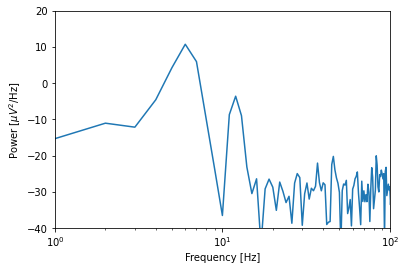

In [5]:
data = sio.loadmat('/content/gdrive/MyDrive/Colab Notebooks/Data/Python EEG/Case-Studies-Python-student/matfiles/04_ECoG-1.mat')    # Load the ECoG data.
x    = data['ECoG'].reshape(-1)          # Extract the ECoG variable,
t    = data['t'][0]                      # ... and the t variable

dt = t[1] - t[0]                         # Define the sampling interval.
N = x.shape[0]                           # Define the total number of data points.
T = N * dt                               # Define the total duration of the data.

x  = hanning(N) * x                      # Apply the Hanning taper to the data.
xf = fft(x - x.mean())                   # Compute Fourier transform of x.
Sxx = 2 * dt ** 2 / T * (xf * conj(xf))  # Compute the spectrum,
Sxx = real(Sxx[:int(len(x) / 2)])        # ... and ignore negative frequencies.

df = 1 / T.max()                         # Determine the frequency resolution.
fNQ = 1 / dt / 2                         # Determine the Nyquist frequency.
faxis = arange(0,fNQ,df)                 # Construct a frequency axis.

semilogx(faxis[1:],10*log10(Sxx[1:]))    # Plot spectrum vs frequency,
xlim([faxis[1], 100])                    # Select frequency range,
ylim([-40, 20])                          # ... and the power range.
xlabel('Frequency [Hz]')                 # Label the axes
ylabel('Power [$\mu V^2$/Hz]')
show()

# Data analysis

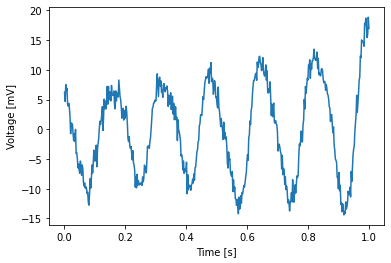

In [6]:
data = sio.loadmat('/content/gdrive/MyDrive/Colab Notebooks/Data/Python EEG/Case-Studies-Python-student/matfiles/04_ECoG-1.mat')  # Load the ECoG data
ecog = data['ECoG'].reshape(-1)   # Extract the ECoG variable
t = data['t'][0]                  # ... and the t variable

plot(t, ecog)                     # Plot the data versus time
xlabel('Time [s]')                # Label the time axis
ylabel('Voltage [mV]')            # ... and the voltage axis
show()

# We see dominant 6Hz rhythm 

# Spectral Analysis: The Rectangular Taper and Zero Padding

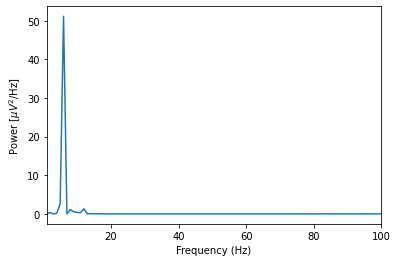

In [7]:
x = ecog          # Relabel the data variable
dt = t[2] - t[1]  # Define the sampling interval
T = t[-1]         # ... and duration of data

xf = rfft(x - x.mean())                        # Compute the Fourier transform of x,
Sxx = real(2 * dt ** 2 / T * (xf * conj(xf)))  # ... and the spectrum.

df = 1 / T                                     # Define the frequency resolution.
fNQ = 1 / dt / 2                               # Define the Nyquist frequency.
faxis = arange(len(Sxx)) * df                  # Construct the frequency axis.
plot(faxis, Sxx)                               # Plot spectrum vs. frequency,
xlim([1, 100])                                 # ... in select frequency range,
xlabel('Frequency (Hz)')                       # ... with axes labeled.
ylabel('Power [$\mu V^2$/Hz]')
show()

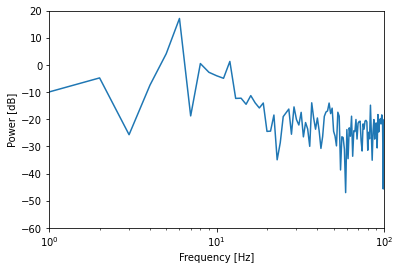

In [8]:
semilogx(faxis, 10 * log10(Sxx)) # Plot spectrum vs frequency,
xlim([1, 100])                      # ... in select frequency range,
ylim([-60, 20])                     # ... and power range,
xlabel('Frequency [Hz]')                # ... with axes labeled.
ylabel('Power [dB]')
show()

# To emphasize smaller peak

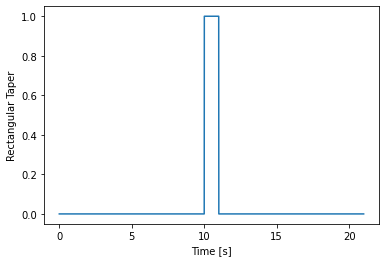

In [9]:
a = zeros(int(10/dt))      # Create 10 s of zeros,
b = ones(int(1/dt))        # ... and 1 s of ones,
taper = hstack((a,b,a))    # ... stack them together,
t = arange(len(taper))*dt  # ... define a time axis,            
plot(t, taper)             # ... and plot taper vs time.
xlabel('Time [s]')         # ... with axes labeled.
ylabel('Rectangular Taper')
show()

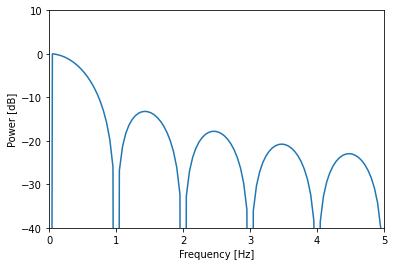

In [10]:
taperf = rfft(taper - taper.mean())                  # Compute Fourier transform of the taper,
Sxx = real( 2*dt**2/t.max() * (taperf*conj(taperf))) # ... and the spectrum,
Sxx = Sxx / Sxx.max()                                # ... scaled to have maximum of 0.

df = 1 /  t.max()                                    # Define the frequency resolution.
fNQ = 1 / dt / 2                                     # Define the Nyquist frequency.
faxis = arange(len(Sxx)) * df                        # Construct frequency axis.

Sxx[Sxx == 0] = nan                                  # Avoid division by 0 errors,
plot(faxis, 10 * log10(Sxx))                         # Plot the spectrum vs frequency,
xlim([0, 5])                                         # ... in select range,
ylim([-40, 10])
xlabel('Frequency [Hz]')                             # ... with axes labeled.
ylabel('Power [dB]')
show()

###Zero padding

In [11]:
### Creating some functions to make padding example easier to display ###

# Create the taper signal
def taper_signal(padding, dt):
  sample_rate = int(1/dt)          # Define the sampling rate.
  a = zeros(sample_rate * padding) # Create an interval of zeros,
  b = ones( sample_rate)           # ... and 1 s of ones,
  taper = hstack((a,b,a))          # ... stack them together,
  t = arange(len(taper)) / sample_rate  # ... define a time axis,
  print(sample_rate)
  return sample_rate, taper          

# Since we have used much of this code before,
# let's make a function out of it. This way we
# can easily reuse it without copying and pasting.

def show_spectrum(x, Fs, x_lim=[0, 10], y_lim=[-40, 10], display=True):
    dt = 1 / Fs                   # Define the time step
    T = len(x) * dt               # Define the total time
    X = rfft(x - x.mean())        # Compute the Fourier transform
    Sxx = real((X * conj(X)))     # ... and the spectrum
    Sxx = Sxx / Sxx.max()         # ... and scale it to have maximum of 0.
    
    df = 1 / T                    # Define the frequency resolution,
    faxis = arange(len(Sxx)) * df # ... to create frequency axis
    
    if display:                   # If you'd like to display the results,
        subplot(1,2,1)
        plot(arange(0, T, dt), x) # ... then plot the signal,
        xlabel('Time [s]')        # ... with axes labeled.
        ylabel('Signal')
        subplot(1,2,2)            # ... and its spectrum
        Sxx[Sxx == 0] = nan       # ... avoid division by 0 errors
        plot(faxis,10.*log10(Sxx))# Plot the spectrum vs frequency,
        xlim(x_lim)               # ... in select range,
        ylim(y_lim)
        xlabel('Frequency [Hz]')  # ... with axes labeled.
        ylabel('Power [dB]')
        show()

    return Sxx, faxis
    
#show_spectrum(taper, sample_rate);# Show the taper and its spectrum
                                  # ... (suppress output with ';')

500


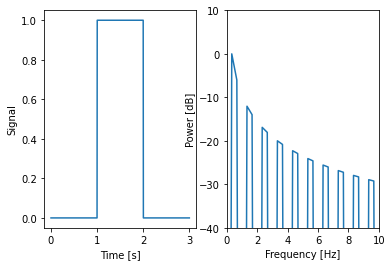

In [12]:
# Decide how many seconds of padding to use.
# Run this code block with 1, 2, and 10 seconds of 
# padding. What do you notice?

sample_rate, taper = taper_signal(1, dt)

show_spectrum(taper, sample_rate);

500


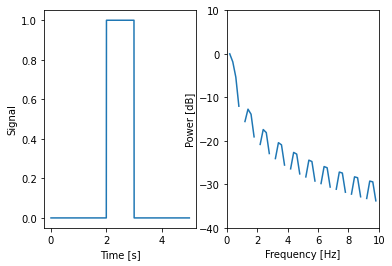

In [13]:
sample_rate, taper = taper_signal(2, dt)

show_spectrum(taper, sample_rate);

500


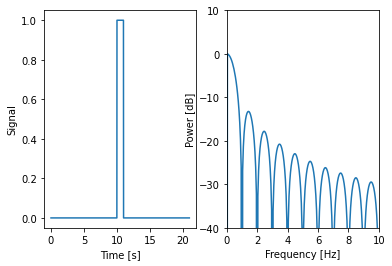

In [14]:
sample_rate, taper = taper_signal(10, dt)

show_spectrum(taper, sample_rate);

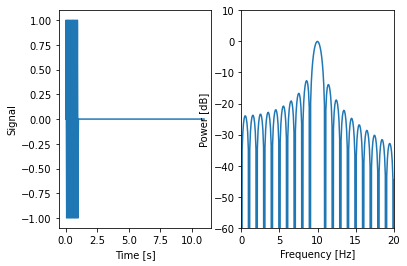

In [15]:
Fs = 500                                    # Define sampling frequency.
d = sin(2. * pi * arange(0, 1, 1/Fs) * 10)  # Make a 10 Hz sinusoid,
d = hstack((d, zeros(10 * Fs)))             # ... with 10 s of zero padding.

# Use the function we created earlier to view the spectrum. 
show_spectrum(d, Fs, x_lim=[0, 20], y_lim=[-60, 10]);

###Zero padding and frequency resolution: an example.

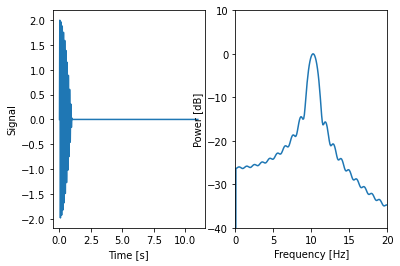

In [16]:
Fs = 500                                       # Define sampling frequency
d1 = sin(2. * pi * arange(0, 1, 1/Fs) * 10)    # Make a 10 Hz sinusoid.
d2 = sin(2. * pi * arange(0, 1, 1/Fs) * 10.5)  # Make a 10.5 Hz sinusoid.
d = d1 + d2                                    # Make the summed signal,
d = hstack((d, zeros(10 * Fs)))                # ... with 10 s of zero padding.

show_spectrum(d, Fs, x_lim=[0, 20], y_lim=[-40, 10]); # ... and compute the spectrum.

# We cannot distinguish between the 10 Hz and 10.5 Hz sinusoid even if we zero pad the data

# Beyond the Rectangular Taper—The Hanning Taper